# Initialize

In [18]:
%load_ext autoreload
%autoreload 2

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt

import pickle

import sys
sys.path.append('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders')

from AE.models import AE_0
from AE.datasets import MNISTDigit2Dataset, MNISTDigit2OnlyDataset, FEMNISTDataset

from AE.overlaps import get_datapoints_labels_arrays
from AE.overlaps import compute_rep_hl_datapoints_labels_freq

from AE.overlaps import compute_overlap_matrix_for_repetitions
from AE.overlaps import plot_overlap_heatmap

from AE.overlaps import compute_entropy_and_dkl
from AE.overlaps import plot_entropy_or_dkltouniform

from AE.overlaps import plot_multiple_distances_histograms
from AE.overlaps import plot_mean_distance_per_hidden_layer

from AE.overlaps import extract_nonzero_freq_per_hidden_layer, plot_multiple_labels_frequencies_histograms

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Utilizzo Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilizzo NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Utilizzo la CPU")

device = torch.device("cpu")  # Fallback to CPU if no GPU is available

SEED = 42
torch.manual_seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Utilizzo Apple Silicon GPU (MPS)



# Datasets


In [3]:

batch_size = 64

## MNIST
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



In [ ]:


## ExtendedMNIST

train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )


## 2MNIST

dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=batch_size, shuffle=True)

batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=batch_size, shuffle=True)

print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")




#-------------------------------------------------------------------


# datasets = ["MNIST", "EMNIST", "2MNIST"]
train_loaders = {
    "MNIST": train_loader_MNIST,
    "EMNIST": train_loader_EMNIST,
    "2MNIST": train_loader_2MNIST
}
val_loaders = {
    "MNIST": val_loader_MNIST,
    "EMNIST": val_loader_EMNIST,
    "2MNIST": val_loader_2MNIST
}

In [4]:

batch_size = 64


train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )




dataset_2MNISTonly_train = MNISTDigit2OnlyDataset(train=True, download=True)
train_loader_2MNISTonly = DataLoader(dataset_2MNISTonly_train, batch_size=batch_size, shuffle=True)

dataset_2MNISTonly_val = MNISTDigit2OnlyDataset(train=False, download=True)
val_loader_2MNISTonly = DataLoader(dataset_2MNISTonly_val, batch_size=batch_size, shuffle=True)




datasets = ["MNIST", "EMNIST", "2MNISTonly"]
train_loaders = {
    "MNIST": train_loader_MNIST,
    "EMNIST": train_loader_EMNIST,
    "2MNISTonly": train_loader_2MNISTonly
}
val_loaders = {
    "MNIST": val_loader_MNIST,
    "EMNIST": val_loader_EMNIST,
    "2MNISTonly": val_loader_2MNISTonly
}


Found 5958 samples of digit '2'
Found 1032 samples of digit '2'


In [ ]:


dataset_FEMNIST_train = FEMNISTDataset(train=True, download=True)
train_loader_FEMNIST = DataLoader(dataset_FEMNIST_train, batch_size=batch_size, shuffle=True)
dataset_FEMNIST_val = FEMNISTDataset(train=False, download=True)
val_loader_FEMNIST = DataLoader(dataset_FEMNIST_val, batch_size=batch_size, shuffle=True)


train_loaders["FEMNIST"] = train_loader_FEMNIST
val_loaders["FEMNIST"] = val_loader_FEMNIST
print(len(train_loader_FEMNIST.dataset))


## FashionMNIST

In [ ]:

train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



# Analysis

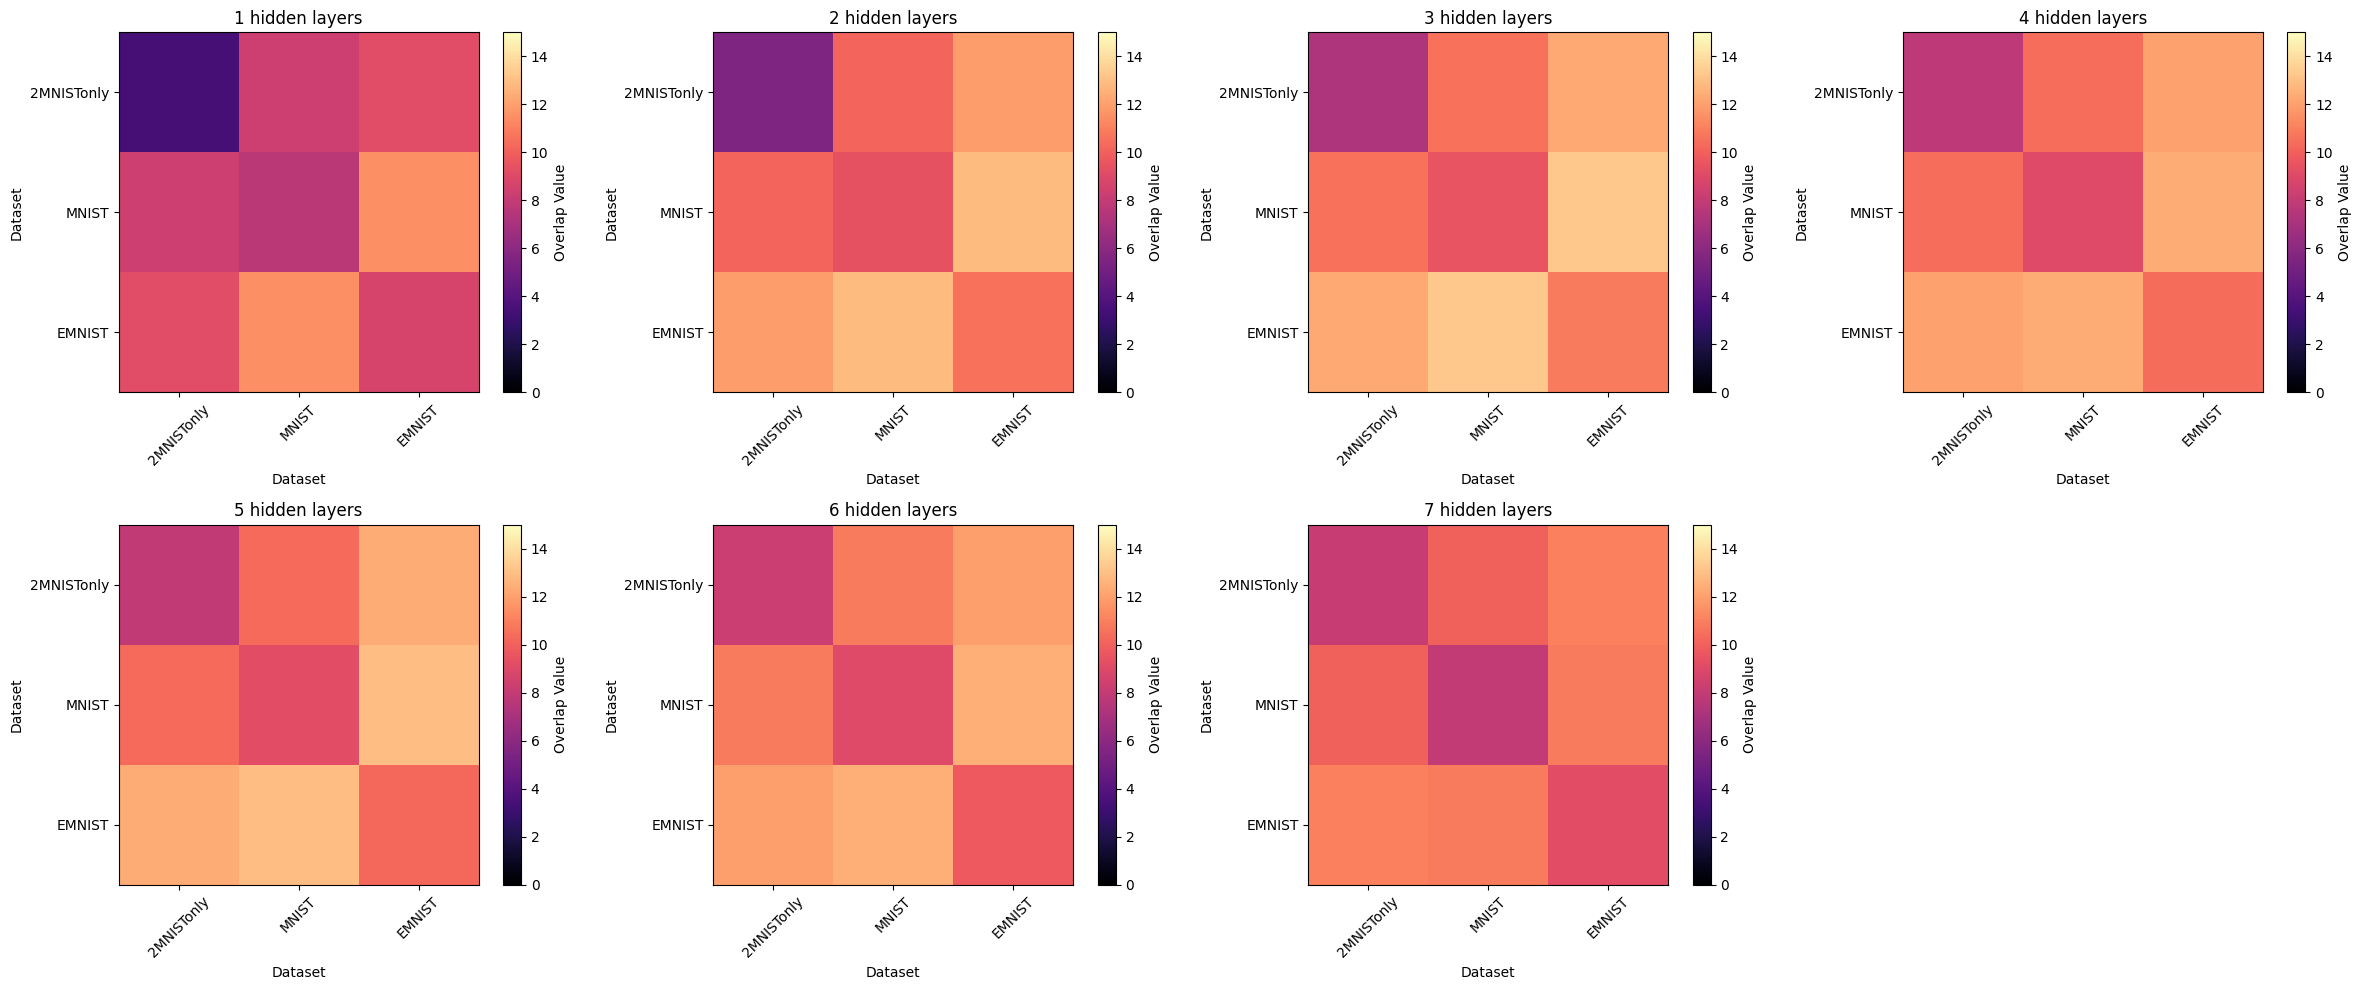

In [8]:
ld = 8

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': ld,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'decrease_rate': '06',
    'learning_rate': '1e3',
    'train_num': 0,
}

datasets = ("2MNISTonly", "MNIST", "EMNIST")

fig, axes = plt.subplots(2, 4, figsize=(24, 10))  # 2 rows, 4 columns

vmax = 15

mean_of_distances_means_dict = {}
mean_of_distances_stds_dict = {}

for i, num_hidden_layers in enumerate(range(1, 8)):
    row = i // 4
    col = i % 4
    model_kwargs['hidden_layers'] = num_hidden_layers
    model_path_kwargs['num_hidden_layers'] = num_hidden_layers
    mean_of_distances_means, mean_of_distances_stds = compute_overlap_matrix_for_repetitions(
        datasets, model_path_kwargs, model_kwargs, repetitions=range(6)
    )
    mean_of_distances_means_dict[num_hidden_layers] = mean_of_distances_means
    mean_of_distances_stds_dict[num_hidden_layers] = mean_of_distances_stds
    # if i == 0:
    #     vmax = np.max(mean_of_distances_means)
    plot_overlap_heatmap(mean_of_distances_means, datasets, title=f"{num_hidden_layers} hidden layers", ax=axes[row, col], vmax=vmax)

axes[1, 3].axis('off')

plt.tight_layout()

plt.savefig(f"../preliminary data/overlaps/images/overlap_matrices_{ld}ld.png")
plt.show()


with open(f"../preliminary data/overlaps/overlaps_{ld}ld.txt", "w") as f:
    for di in range(len(datasets)):
        for dj in range(len(datasets)):
            f.write(f"{datasets[di]} to {datasets[dj]} \n")
            for num_hidden_layers in range(1, 8):
                f.write(f"d({num_hidden_layers}) = {mean_of_distances_means_dict[num_hidden_layers][di, dj]:.4f} \n")
                f.write(f"std({num_hidden_layers}) = {mean_of_distances_stds_dict[num_hidden_layers][di, dj]:.4f} \n")
            f.write("\n")

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap_means_vs_hidden_layers(mean_of_distances_means_dict):
    """
    Plots the mean value of each overlap heatmap as a function of the number of hidden layers.

    Args:
        mean_of_distances_means_dict (dict): 
            Keys are number of hidden layers, values are 2D numpy arrays (heatmaps).
    """
    hidden_layers = []
    heatmap_means = []
    for hl, heatmap in mean_of_distances_means_dict.items():
        hidden_layers.append(hl)
        heatmap_means.append(np.mean(heatmap))
    plt.figure(figsize=(8, 5))
    plt.plot(hidden_layers, heatmap_means, marker='o')
    plt.xlabel('Number of Hidden Layers')
    plt.ylabel('Mean of Overlap Heatmap')
    plt.title('Mean Overlap vs Number of Hidden Layers')
    plt.grid(True)
    plt.show()

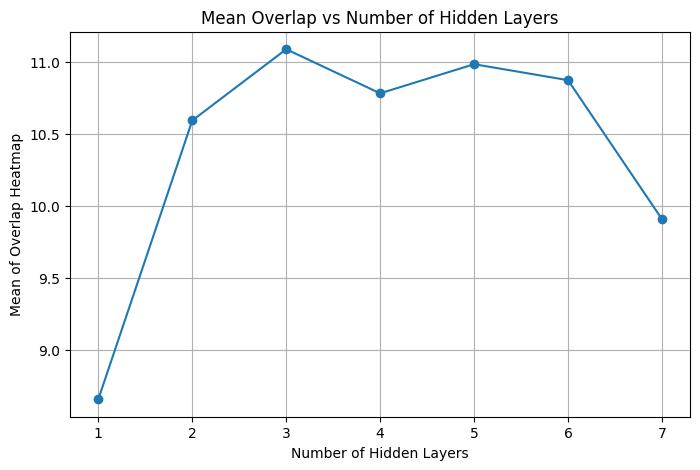

In [17]:
plot_heatmap_means_vs_hidden_layers(mean_of_distances_means_dict)

# Superposition

In [19]:
from AE.plotter_functions import visualize_bottleneck_neurons
from AE.overlaps import load_model
from AE.plotter_functions import visualize_decoded_from_latent_vectors, plot_original_vs_decoded

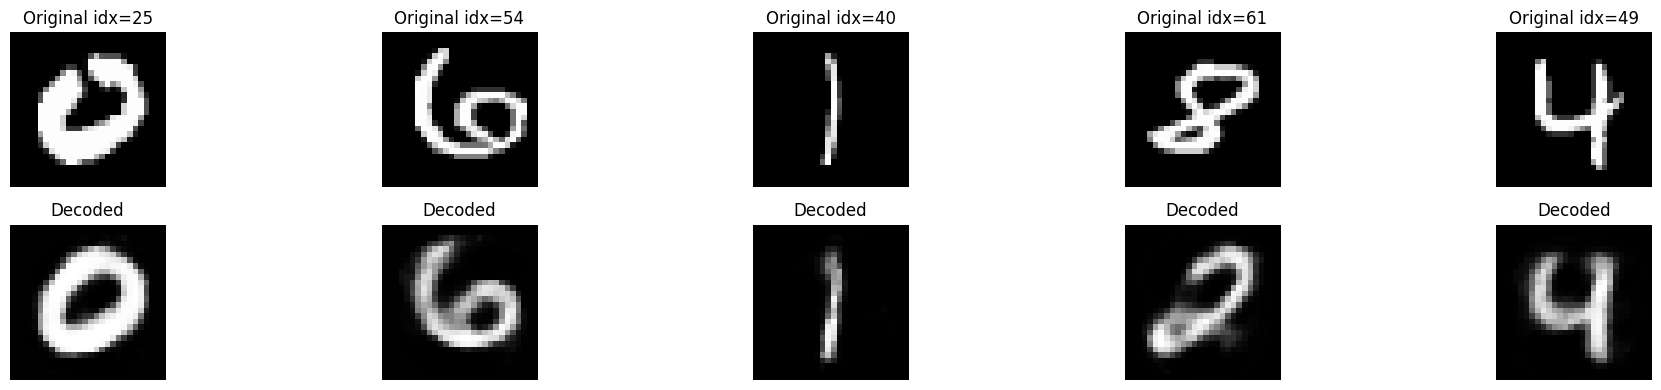

In [24]:
from AE.overlaps import load_model

ld = 8
num_hidden_layers = 7

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': ld,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'decrease_rate': '06',
    'learning_rate': '1e3',
    'train_num': 0,
}

model_kwargs['hidden_layers'] = num_hidden_layers
model_path_kwargs['num_hidden_layers'] = num_hidden_layers
model_path_kwargs['dataset'] = 'MNIST'


model = load_model(model_path_kwargs, model_kwargs)

plot_original_vs_decoded(model, val_loader_MNIST, device=device)

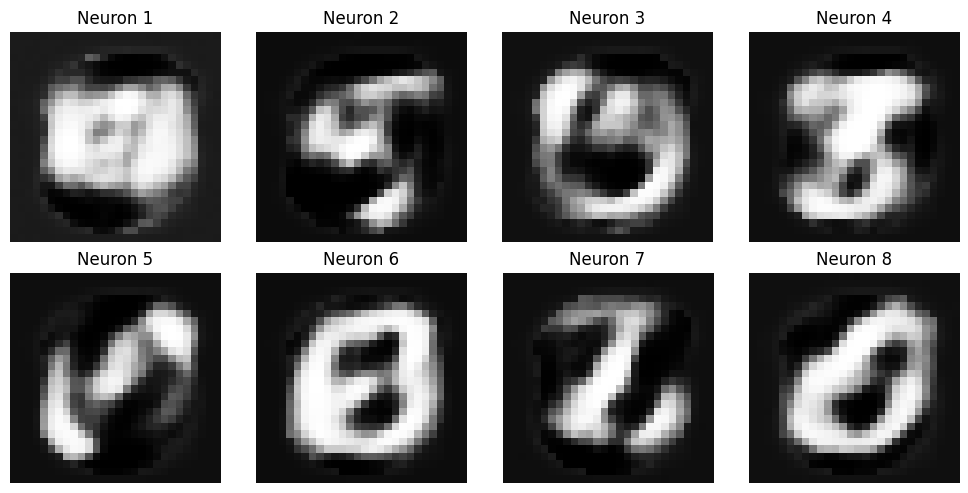

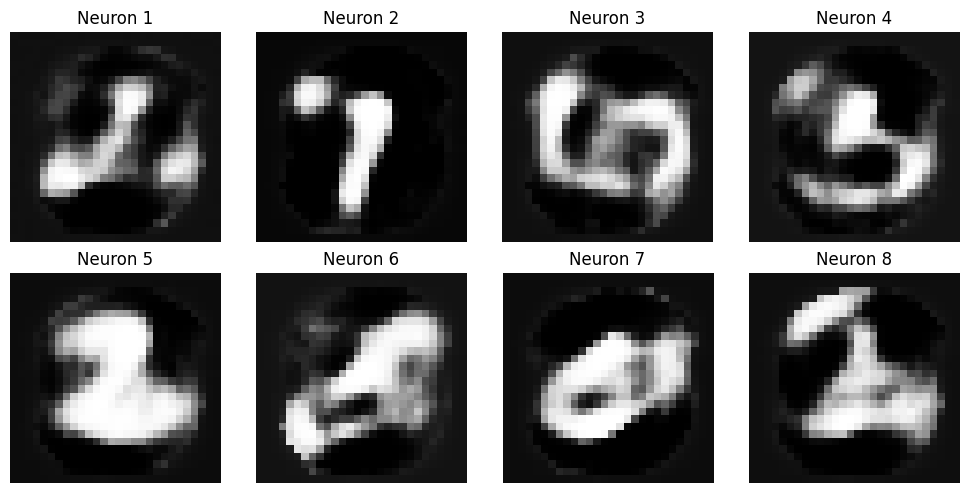

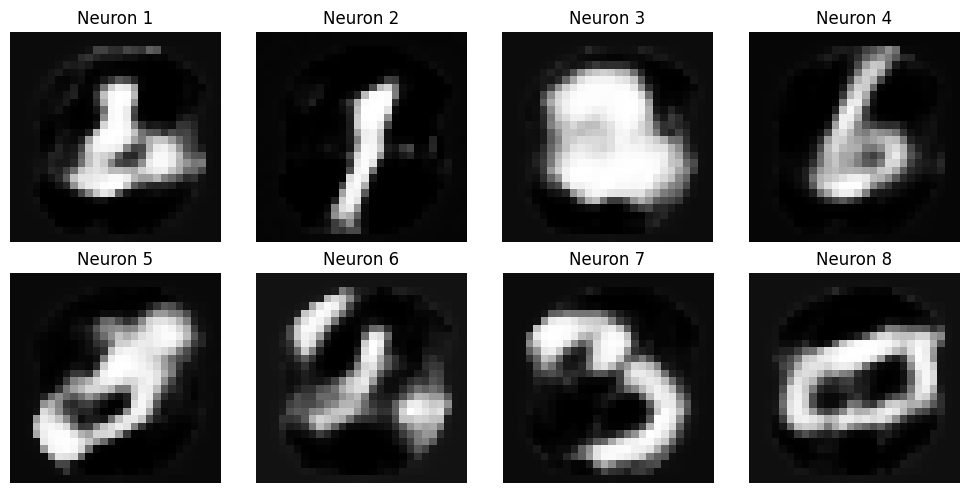

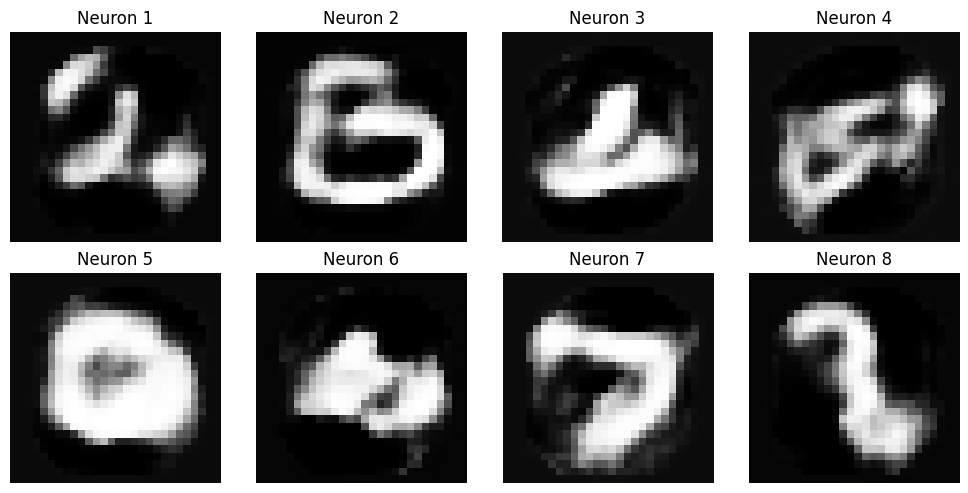

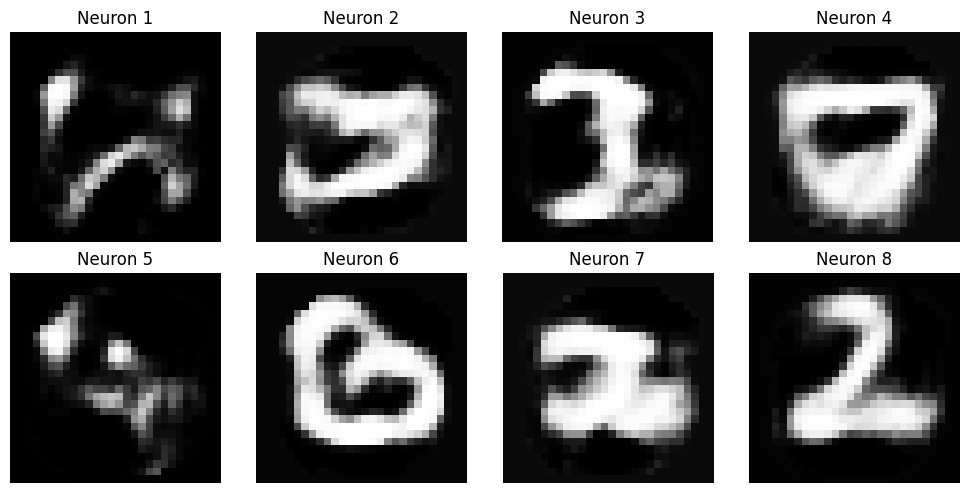

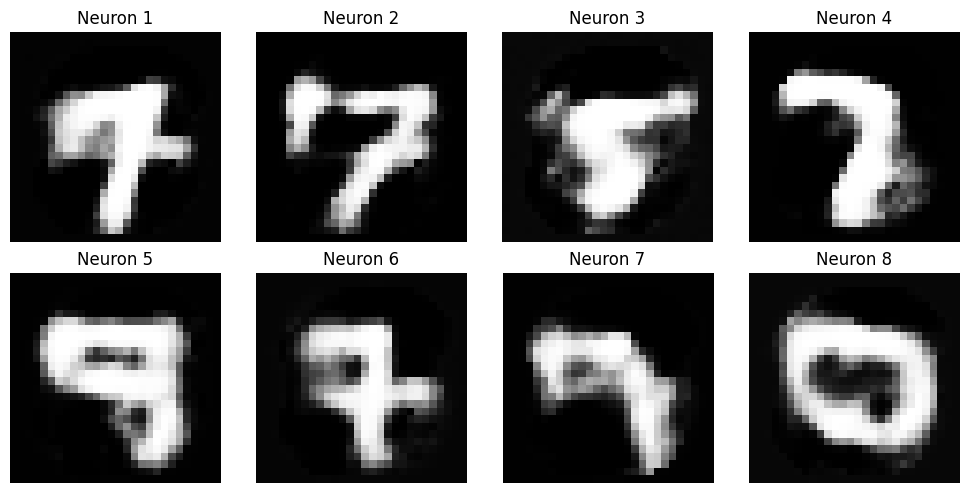

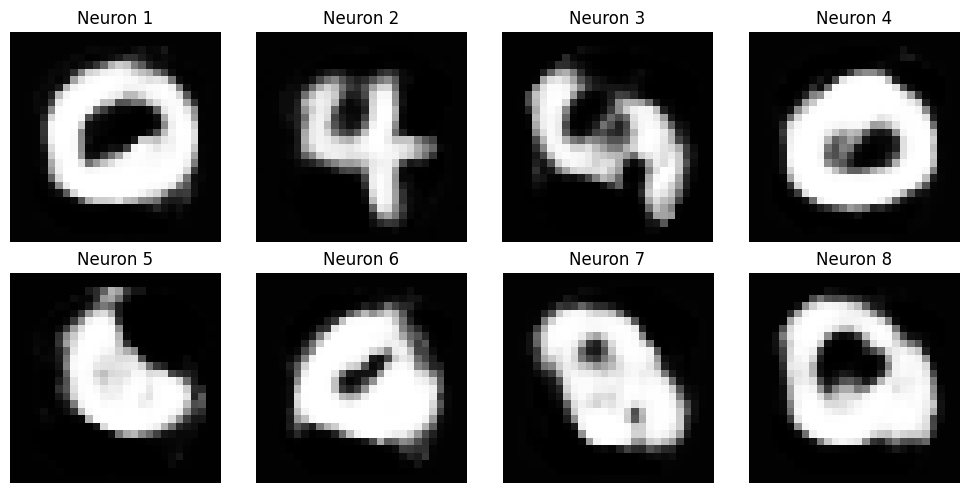

In [26]:
ld = 8

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': ld,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'decrease_rate': '06',
    'learning_rate': '1e3',
    'train_num': 0,
}

for num_hidden_layers in range(1, 8):
    model_kwargs['hidden_layers'] = num_hidden_layers
    model_path_kwargs['num_hidden_layers'] = num_hidden_layers
    model_path_kwargs['dataset'] = 'MNIST'

    my_model = load_model(model_path_kwargs, model_kwargs)

    visualize_bottleneck_neurons(my_model, device, img_shape=(28, 28))

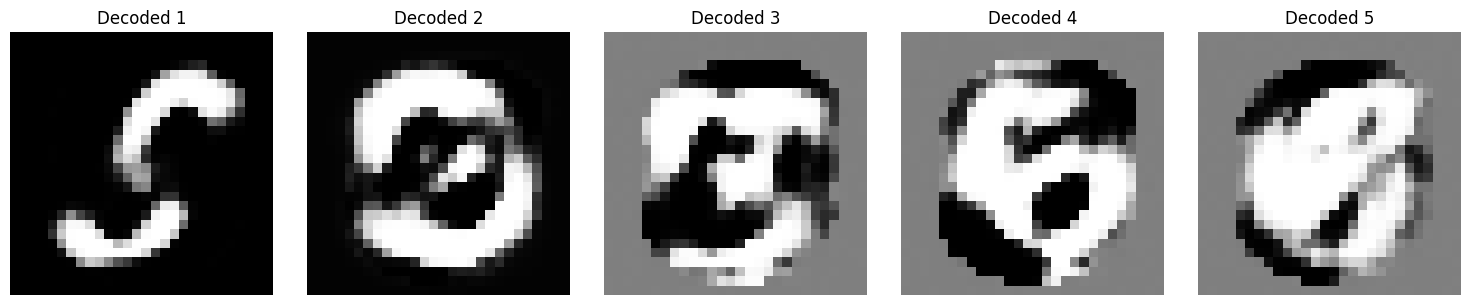

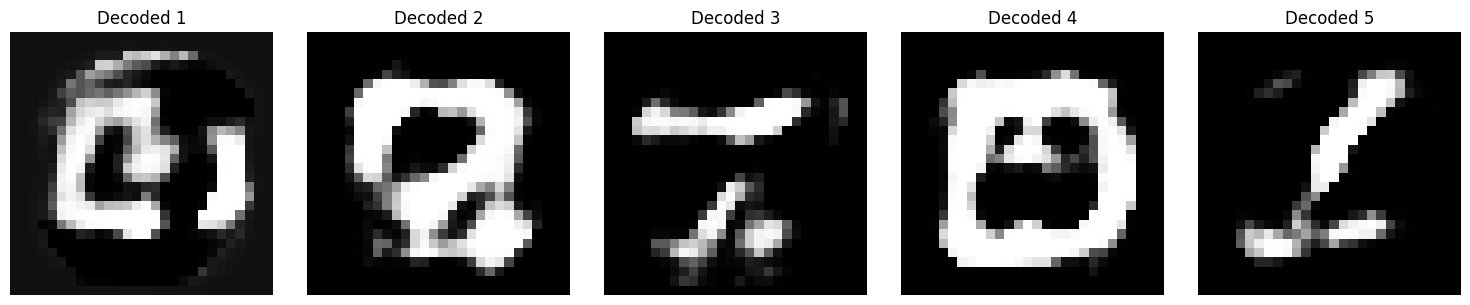

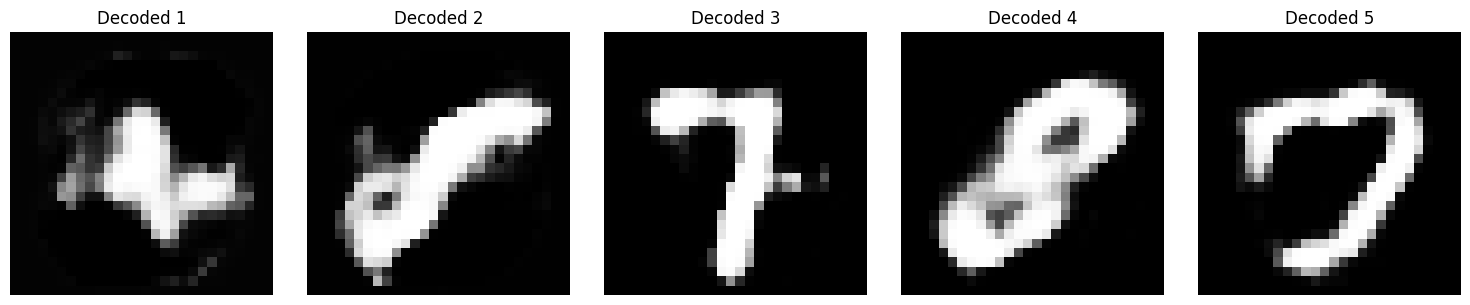

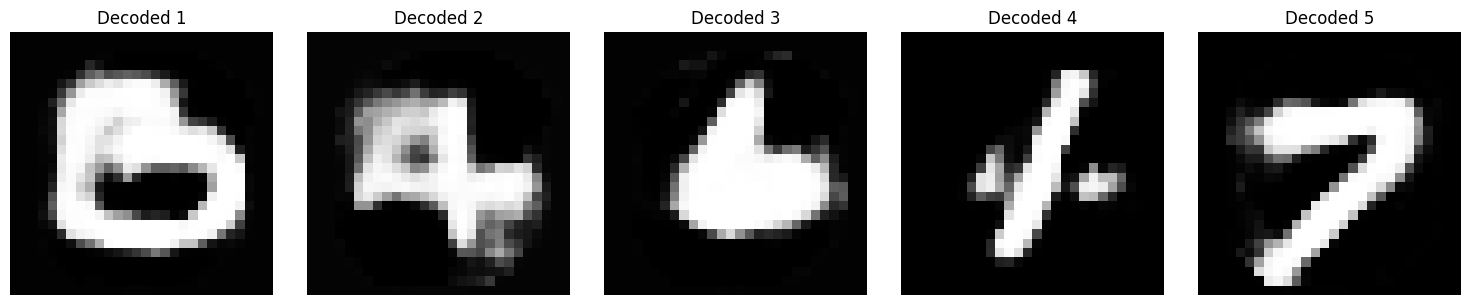

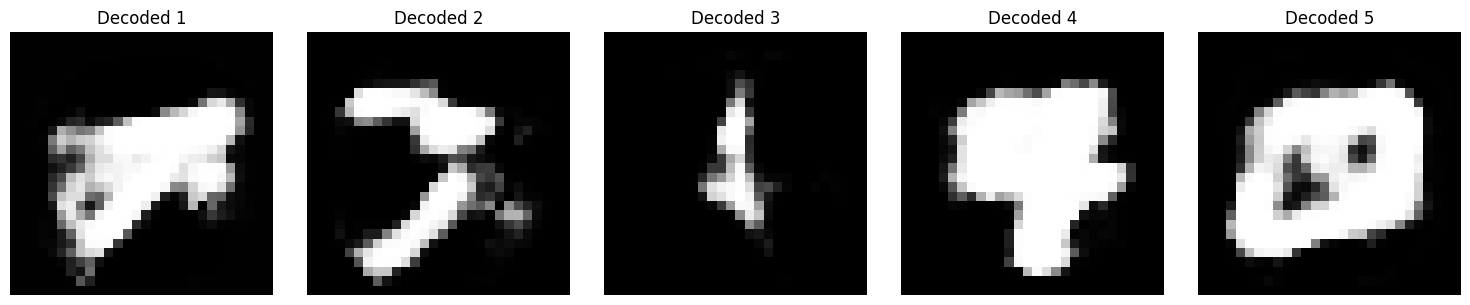

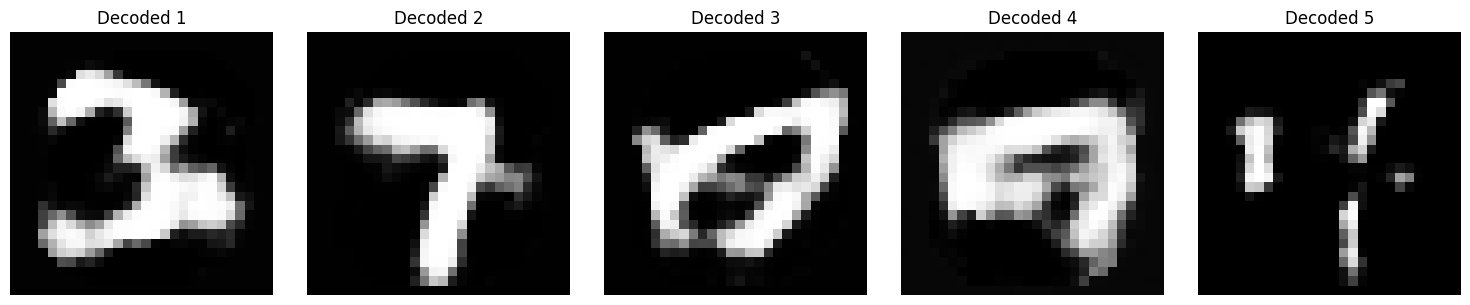

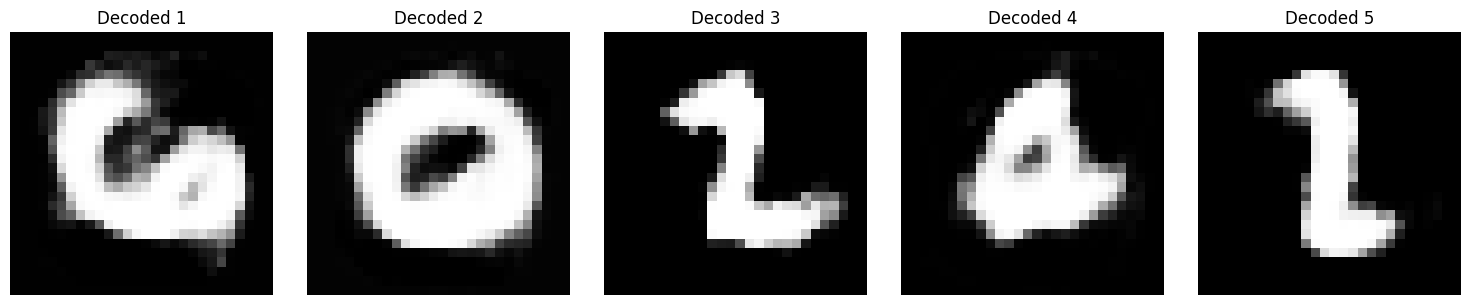

In [28]:
ld = 8

model_kwargs = {
    'input_dim': 28*28,
    'latent_dim': ld,
    'decrease_rate': 0.6,
    'device': device,
    'output_activation_encoder': nn.Sigmoid
}
model_path_kwargs = {
    'output_activation_encoder': 'sigmoid output',
    'train_type': 'simultaneous train',
    'latent_dim': f"{model_kwargs['latent_dim']}ld",
    'decrease_rate': '06',
    'learning_rate': '1e3',
    'train_num': 0,
}

for num_hidden_layers in range(1, 8):
    model_kwargs['hidden_layers'] = num_hidden_layers
    model_path_kwargs['num_hidden_layers'] = num_hidden_layers
    model_path_kwargs['dataset'] = 'MNIST'

    my_model = load_model(model_path_kwargs, model_kwargs)

    # For a batch of vectors
    latent_matrix = torch.randn(5, my_model.latent_dim)
    visualize_decoded_from_latent_vectors(my_model, latent_matrix, device)

# Features/datapoints memorization

## Minimum distance

In [59]:
ld = 10
dataset = 'MNIST'

with open(f"../savings/features freq/datapoints_freq_list_{dataset}_{ld}ld.pkl", "rb") as f:
    datapoints_freq_list_loaded = pickle.load(f)
with open(f"../savings/features freq/labels_freq_list_{dataset}_{ld}ld.pkl", "rb") as f:
    labels_freq_list_loaded = pickle.load(f)


In [3]:
dataset = 'MNIST'
ld = 10

save_dir = "../savings/features freq"
datapoints_array, labels_array = get_datapoints_labels_arrays(dataset, train=True)
datapoints_freq_list, labels_freq_list = compute_datapoints_labels_freq_list(dataset, ld=ld, datapoints_array=datapoints_array, labels_array=labels_array, device=device, save_dir=None)
with open(f"{save_dir}/rep_hl_datapoints_freq_{dataset}_{ld}ld.pkl", "wb") as f:
    pickle.dump(datapoints_freq_list, f)
with open(f"{save_dir}/rep_hl_labels_freq_{dataset}_{ld}ld.pkl", "wb") as f:
    pickle.dump(labels_freq_list, f)


In [4]:
from AE.overlaps import compute_distances_list

save_dir = "../savings/features freq"
datapoints_array, labels_array = get_datapoints_labels_arrays(dataset, train=True)
distances_list = compute_distances_list(dataset, ld=ld, datapoints_array=datapoints_array, device=device)
with open(f"{save_dir}/rep_hl_distances_{dataset}_{ld}ld.pkl", "wb") as f:
    pickle.dump(distances_list, f)


In [ ]:
from AE.overlaps import compute_min_distances

distances = compute_min_distances(model_path_kwargs, model_kwargs, datapoints_array)

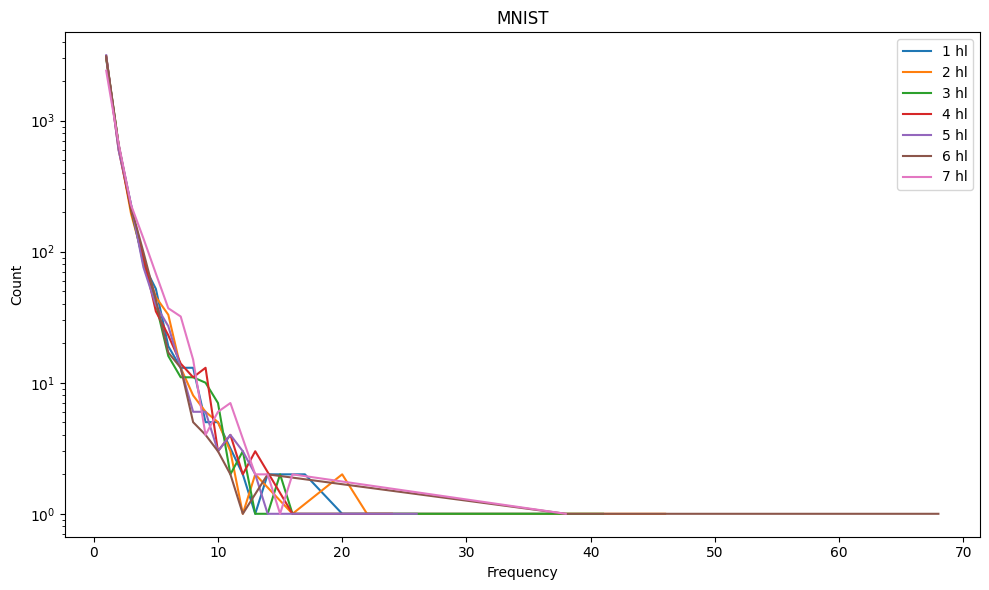

In [5]:
hl_datapoints_freq_sum = np.sum(datapoints_freq_list, axis=0)
hl_unique_frequencies, hl_unique_counts = extract_unique_freq_counts_per_hidden_layer(hl_datapoints_freq_sum)

plot_multiple_unique_frequencies_lines(hl_unique_frequencies, hl_unique_counts, cmap_name='tab10', title='MNIST')

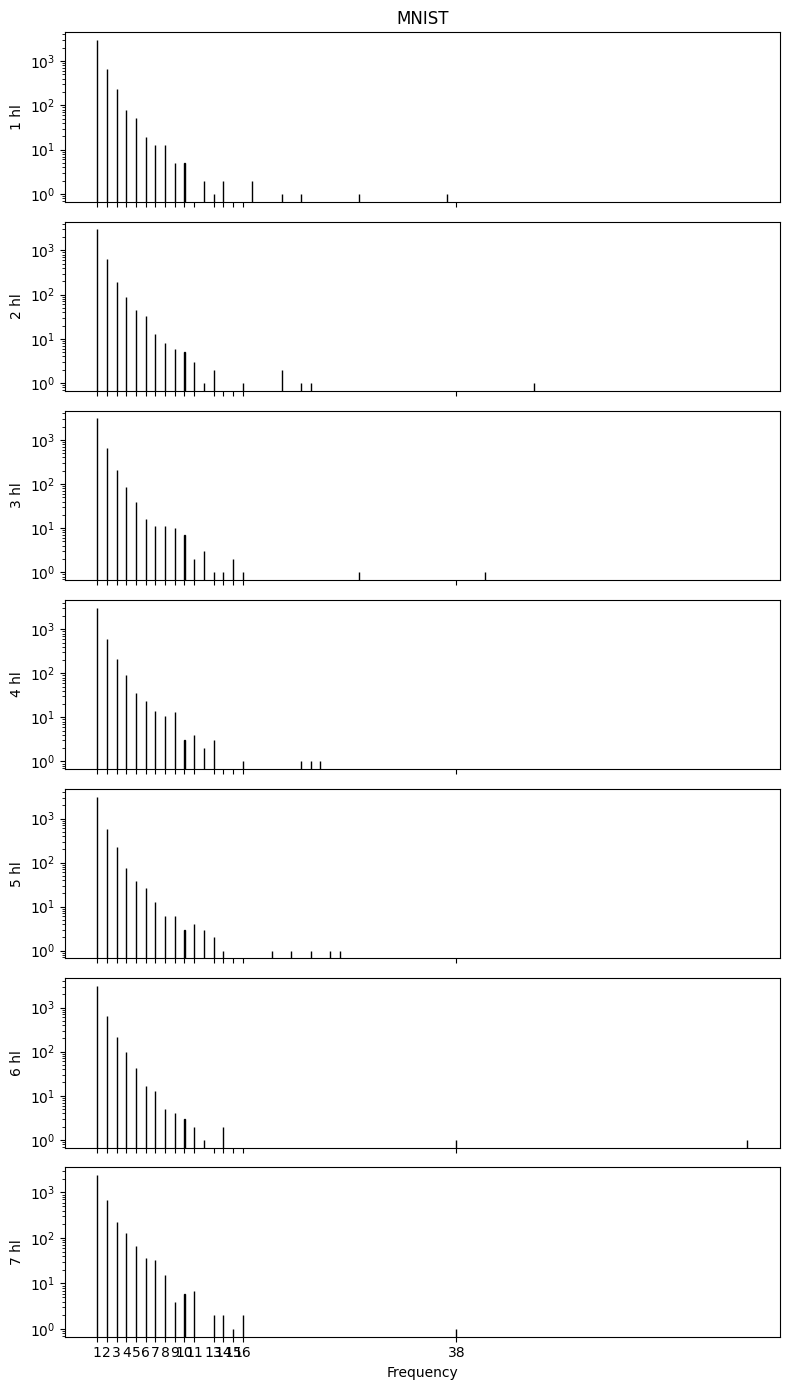

In [6]:
hl_datapoints_freq_sum = np.sum(datapoints_freq_list, axis=0)
hl_unique_frequencies, hl_unique_counts = extract_unique_freq_counts_per_hidden_layer(hl_datapoints_freq_sum)

plot_multiple_unique_frequencies_histograms(hl_unique_frequencies, hl_unique_counts, title = dataset)

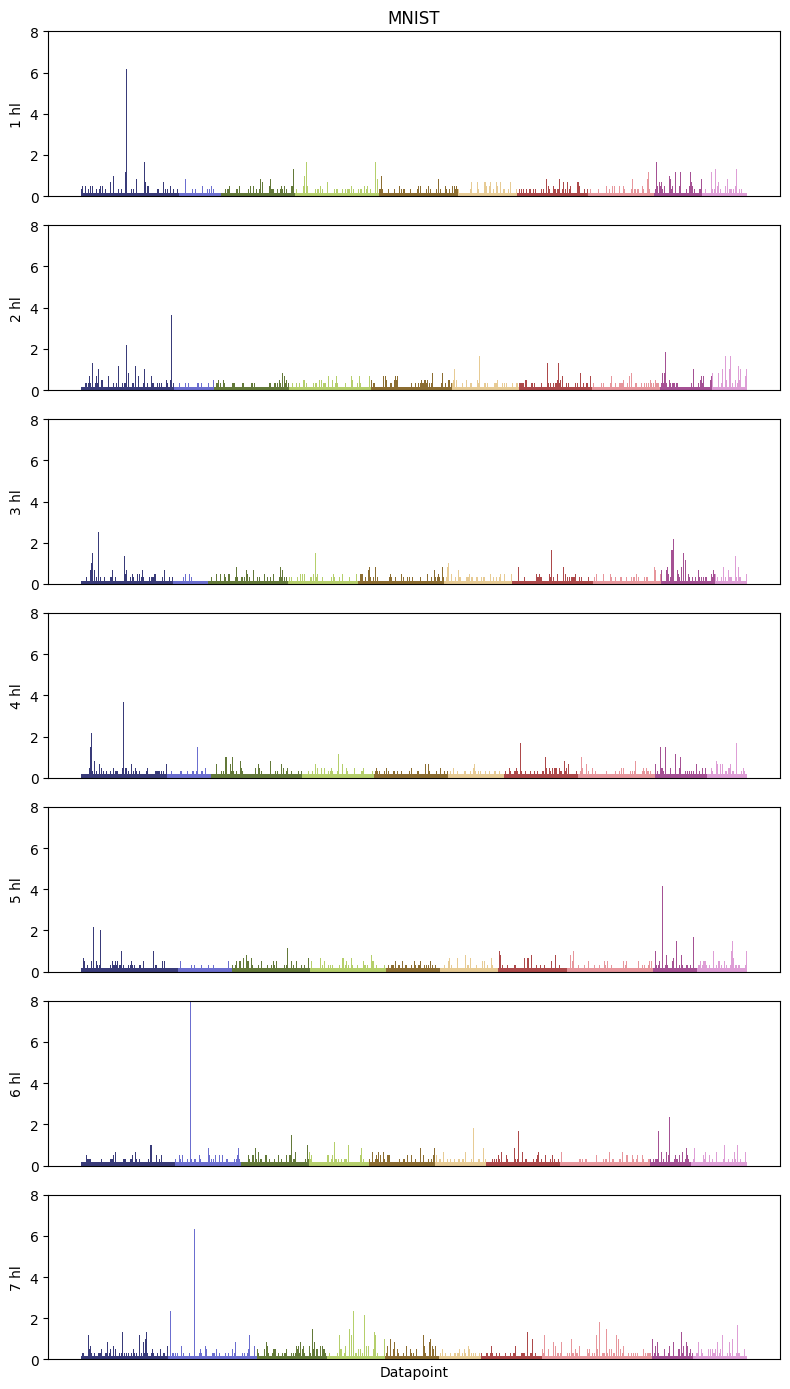

In [12]:

hl_datapoints_freq_mean = np.mean(datapoints_freq_list, axis=0)
hl_datapoints_nonzero_frequencies, hl_nonzero_labels = extract_nonzero_freq_per_hidden_layer(hl_datapoints_freq_mean, labels_array)
plot_multiple_labels_frequencies_histograms(hl_datapoints_nonzero_frequencies, hl_nonzero_labels, dataset, cmap_name='tab20b', y_range =(0,8))

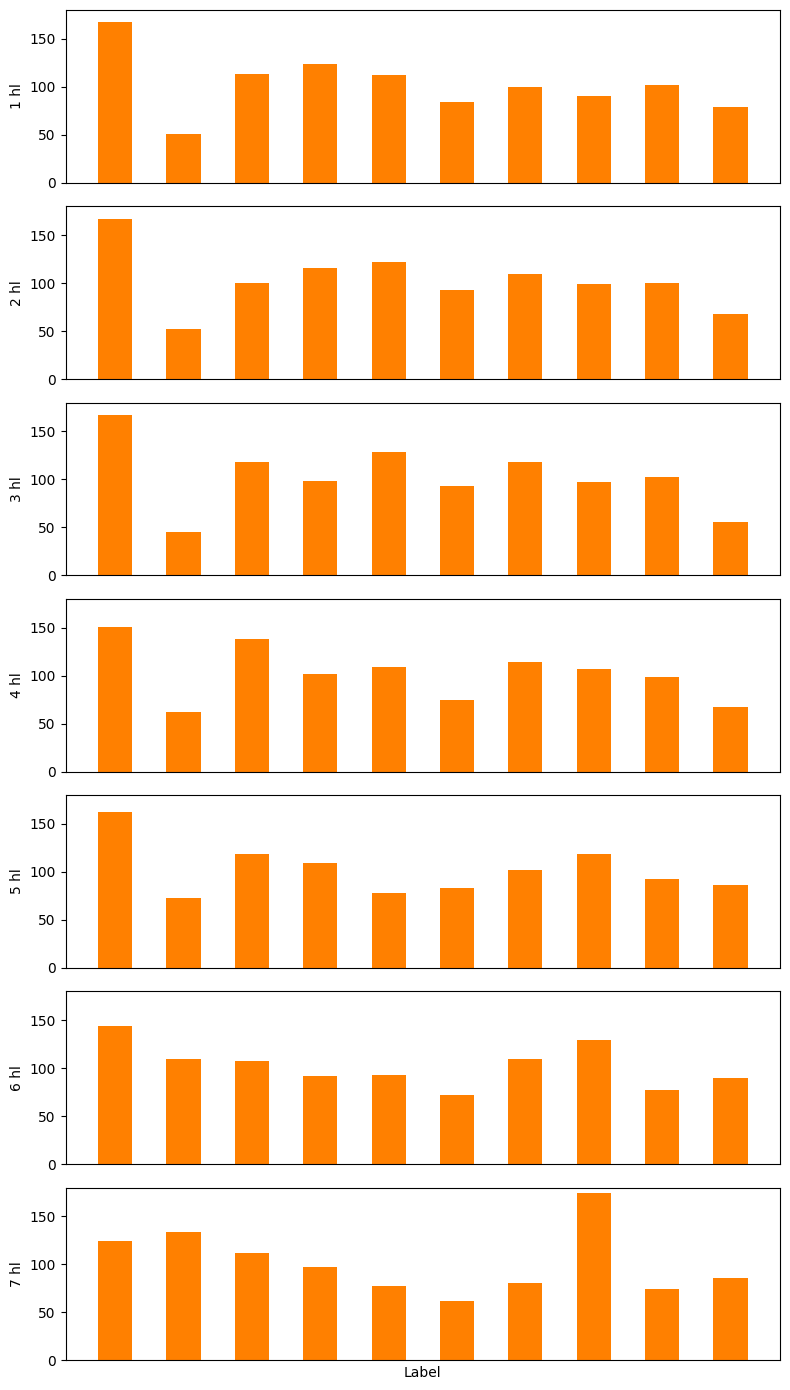

In [13]:
hl_labels_freq_mean = np.mean(labels_freq_list, axis=0)
plot_multiple_labels_frequencies_histograms(hl_labels_freq_mean, cmap_name='autumn', y_range=(0,180))

## Supplementary analysis

In [48]:
ld = 10
dataset = 'MNIST'

with open(f"../savings/features freq/rep_hl_datapoints_freq_{dataset}_{ld}ld.pkl", "rb") as f:
    rep_hl_datapoints_freq_loaded = pickle.load(f)
with open(f"../savings/features freq/rep_hl_labels_freq_{dataset}_{ld}ld.pkl", "rb") as f:
    rep_hl_labels_freq_loaded = pickle.load(f)
with open(f"../savings/features freq/rep_hl_distances_{dataset}_{ld}ld.pkl", "rb") as f:
    rep_hl_distances_loaded = pickle.load(f)

### Entropy

In [13]:
from AE.overlaps import compute_entropy_and_dkl
from AE.overlaps import plot_entropy_or_dkltouniform

In [42]:
entropy_mean, dkl_uniform = compute_entropy_and_dkl(datapoints_freq_list_loaded)
print(entropy_mean.shape, dkl_uniform.shape)

(7,) (7,)


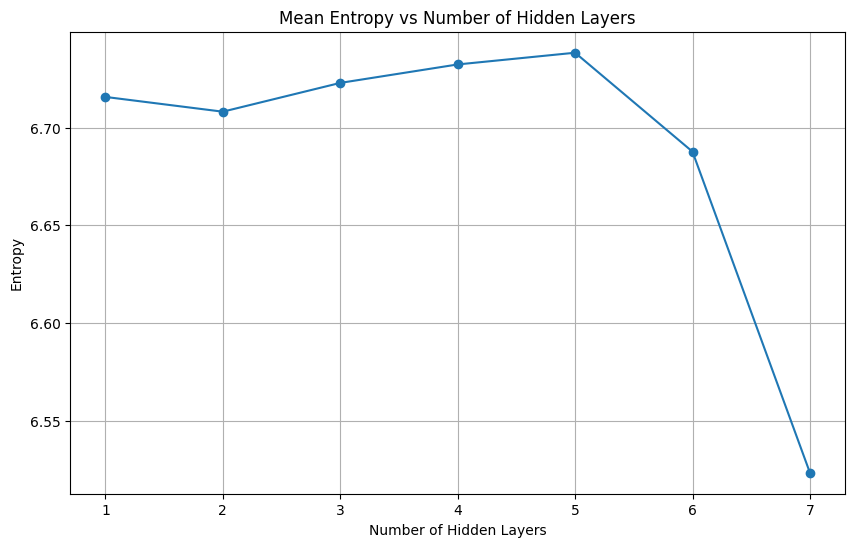

In [45]:
plot_entropy_or_dkltouniform(entropy_mean, 'Entropy', 'Mean Entropy vs Number of Hidden Layers', ld, dataset, save_dir=None)

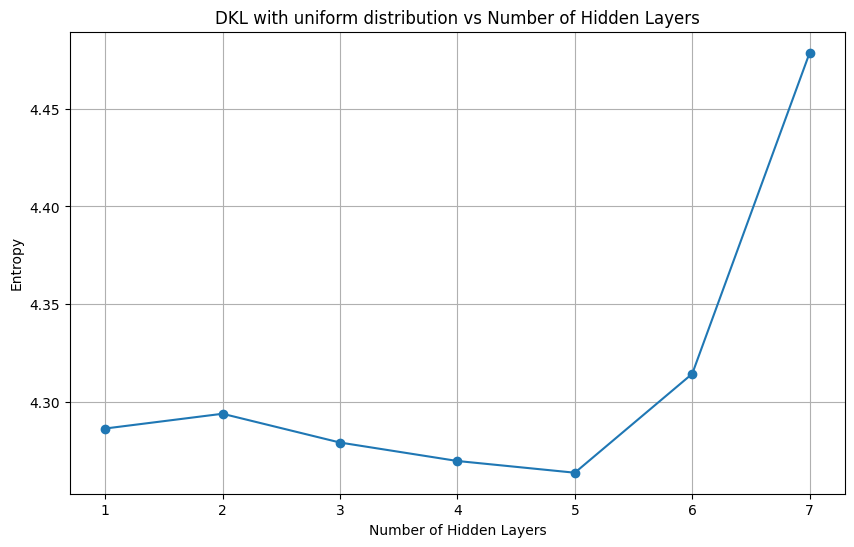

In [47]:
plot_entropy_or_dkltouniform(dkl_uniform, 'Entropy', 'DKL with uniform distribution vs Number of Hidden Layers', ld, dataset, save_dir=None)

### mean distance

In [ ]:
from AE.overlaps import plot_multiple_distances_histograms
from AE.overlaps import plot_mean_distance_per_hidden_layer

In [ ]:
rep_hl_distances_loaded_mean = np.mean(rep_hl_distances_loaded, axis=0)
rep_hl_distances_loaded_mean_sorted = np.sort(rep_hl_distances_loaded_mean, axis=1)[:, ::-1]

In [60]:
x_range = []
for i in range(rep_hl_distances_loaded_mean.shape[0]):
    x_range.append(np.arange(rep_hl_distances_loaded_mean.shape[1]))

[array([   0,    1,    2, ..., 1021, 1022, 1023], shape=(1024,)), array([   0,    1,    2, ..., 1021, 1022, 1023], shape=(1024,)), array([   0,    1,    2, ..., 1021, 1022, 1023], shape=(1024,)), array([   0,    1,    2, ..., 1021, 1022, 1023], shape=(1024,)), array([   0,    1,    2, ..., 1021, 1022, 1023], shape=(1024,)), array([   0,    1,    2, ..., 1021, 1022, 1023], shape=(1024,)), array([   0,    1,    2, ..., 1021, 1022, 1023], shape=(1024,))]


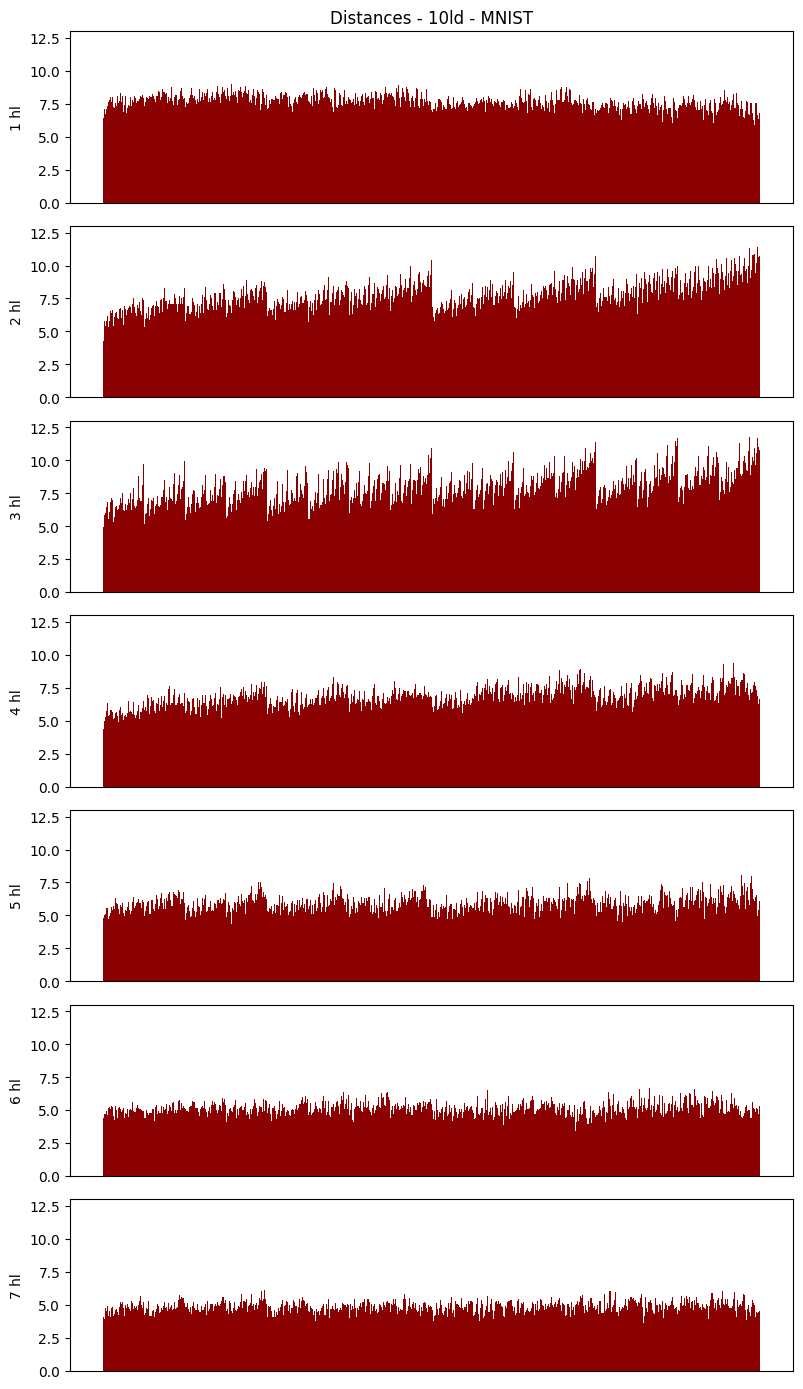

In [116]:
plot_multiple_distances_histograms(x_range, rep_hl_distances_loaded_mean, title=f"Distances - {ld}ld - {dataset}", y_range=(0,13))

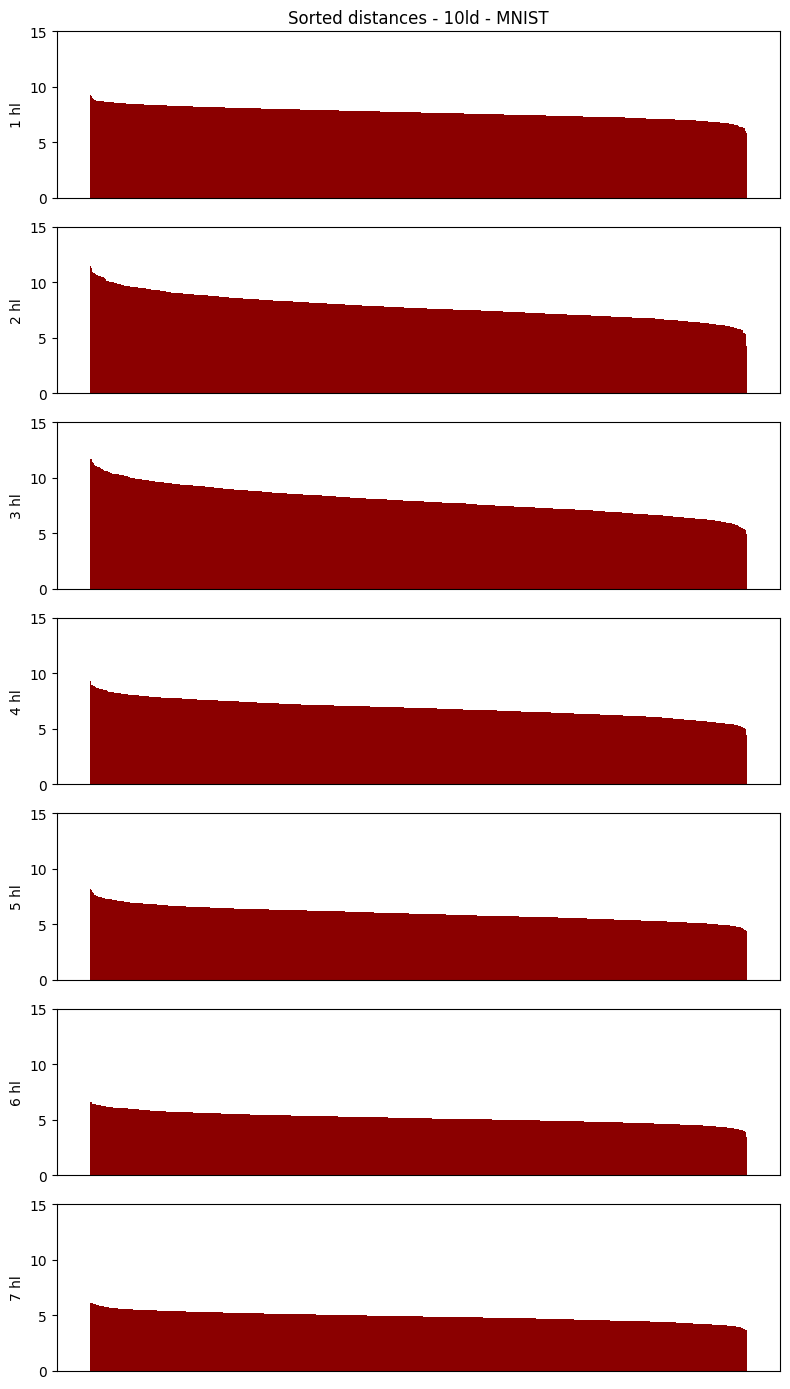

In [119]:
plot_multiple_distances_histograms(x_range, rep_hl_distances_loaded_mean_sorted, title=f"Sorted distances - {ld}ld - {dataset}", y_range=(0, 15))

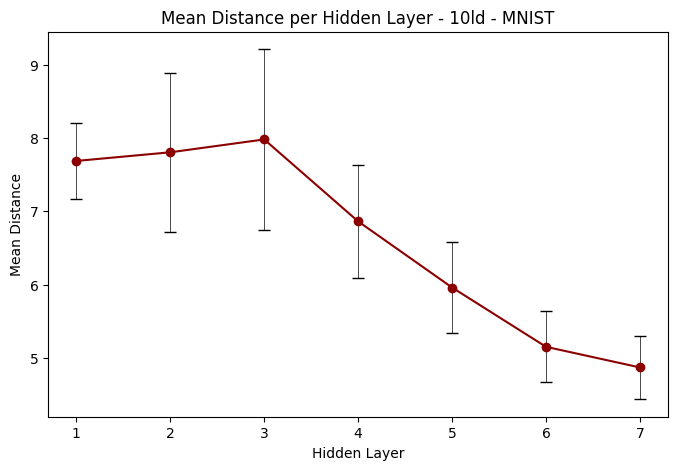

In [120]:
rep_hl_distances_loaded_mean_mean = np.mean(rep_hl_distances_loaded_mean, axis=1)
rep_hl_distances_loaded_mean_std = np.std(rep_hl_distances_loaded_mean, axis=1)

plot_mean_distance_per_hidden_layer(rep_hl_distances_loaded_mean_mean, rep_hl_distances_loaded_mean_std, ld, dataset)

## l1 regularization

## clean analysys

In [12]:
dataset = 'MNIST'
datapoints_array, labels_array = get_datapoints_labels_arrays(dataset, train=True)

In [30]:
ld = 8
dataset = 'MNIST'
train_num = 1

with open(f"../savings/features freq/rep_hl_datapoints_freq_{dataset}_{ld}ld_sigm_output_l1_reg.pkl", "rb") as f:
    rep_hl_datapoints_freq_loaded = pickle.load(f)
with open(f"../savings/features freq/rep_hl_labels_freq_{dataset}_{ld}ld_sigm_output_l1_reg.pkl", "rb") as f:
    rep_hl_labels_freq_loaded = pickle.load(f)
with open(f"../savings/features freq/rep_hl_distances_{dataset}_{ld}ld_sigm_output_l1_reg.pkl", "rb") as f:
    rep_hl_distances_loaded = pickle.load(f)

In [34]:
dataset = 'MNIST'
ld = 8

save_dir = "../savings/features freq"

rep_hl_datapoints_freq, rep_hl_labels_freq, rep_hl_distances  = compute_rep_hl_datapoints_labels_freq(
    dataset,
    ld=ld,
    datapoints_array=datapoints_array,
    labels_array=labels_array,
    device=device,
    return_distances=True,
    save_dir=None
)

with open(f"{save_dir}/rep_hl_datapoints_freq_{dataset}_{ld}ld_sigm_output_l1_reg.pkl", "wb") as f:
    pickle.dump(rep_hl_datapoints_freq, f)
with open(f"{save_dir}/rep_hl_labels_freq_{dataset}_{ld}ld_sigm_output_l1_reg.pkl", "wb") as f:
    pickle.dump(rep_hl_labels_freq, f)
with open(f"{save_dir}/rep_hl_distances_{dataset}_{ld}ld_sigm_output_l1_reg.pkl", "wb") as f:
    pickle.dump(rep_hl_distances, f)

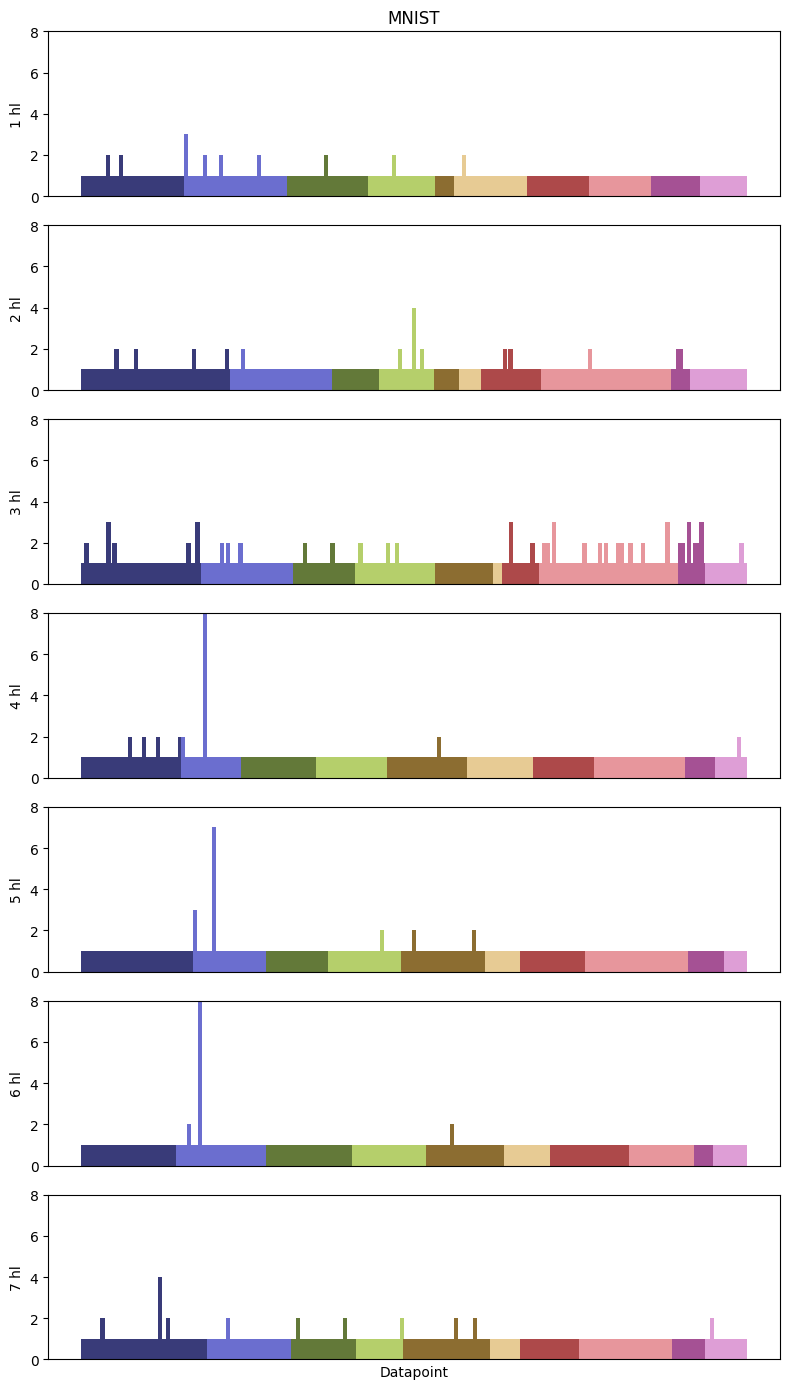

In [31]:

hl_datapoints_freq_mean = np.mean(rep_hl_datapoints_freq_loaded, axis=0)
hl_datapoints_nonzero_frequencies, hl_nonzero_labels = extract_nonzero_freq_per_hidden_layer(hl_datapoints_freq_mean, labels_array)
plot_multiple_labels_frequencies_histograms(hl_datapoints_nonzero_frequencies, hl_nonzero_labels, dataset, cmap_name='tab20b', y_range =(0,8))


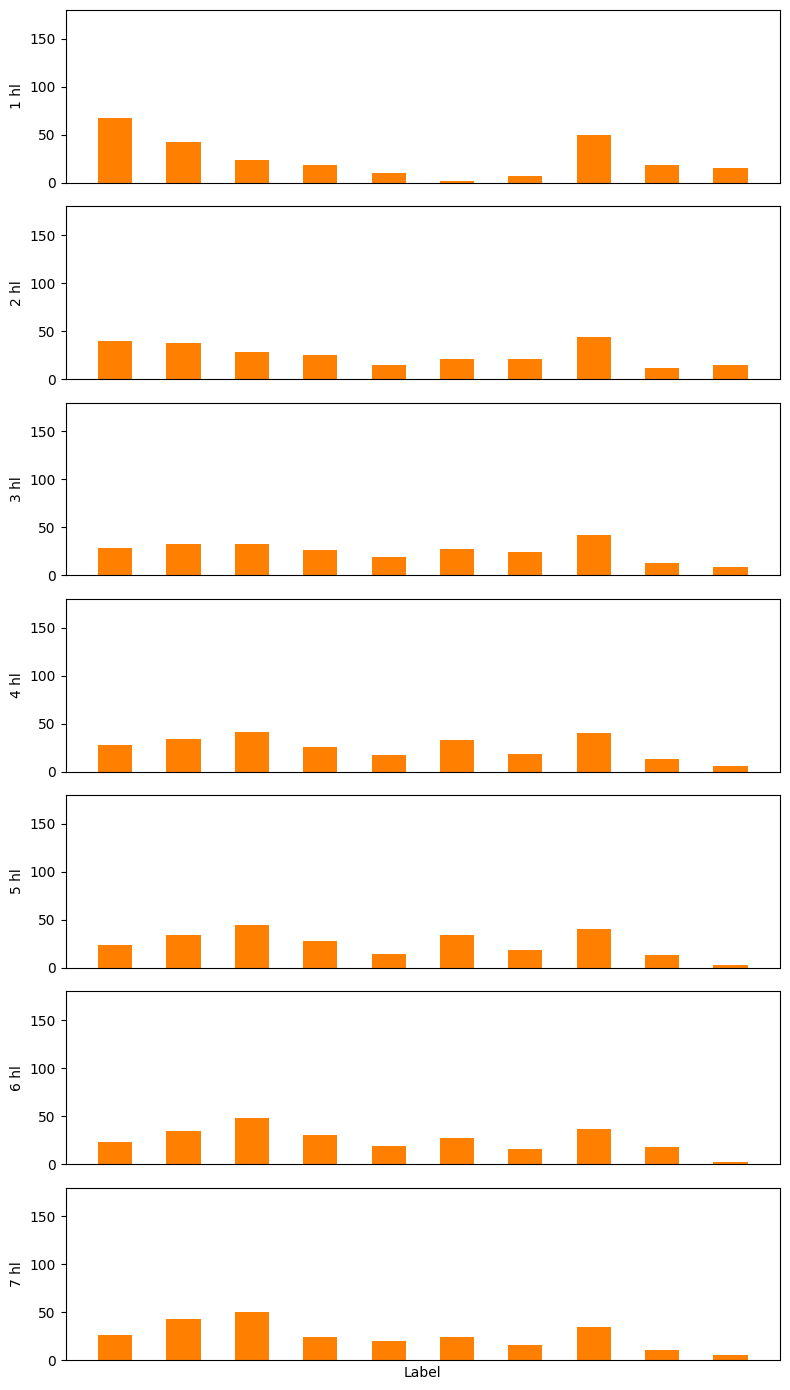

In [32]:
hl_labels_freq_mean = np.mean(rep_hl_labels_freq_loaded, axis=0)
plot_multiple_labels_frequencies_histograms(hl_labels_freq_mean, cmap_name='autumn', y_range=(0,180))

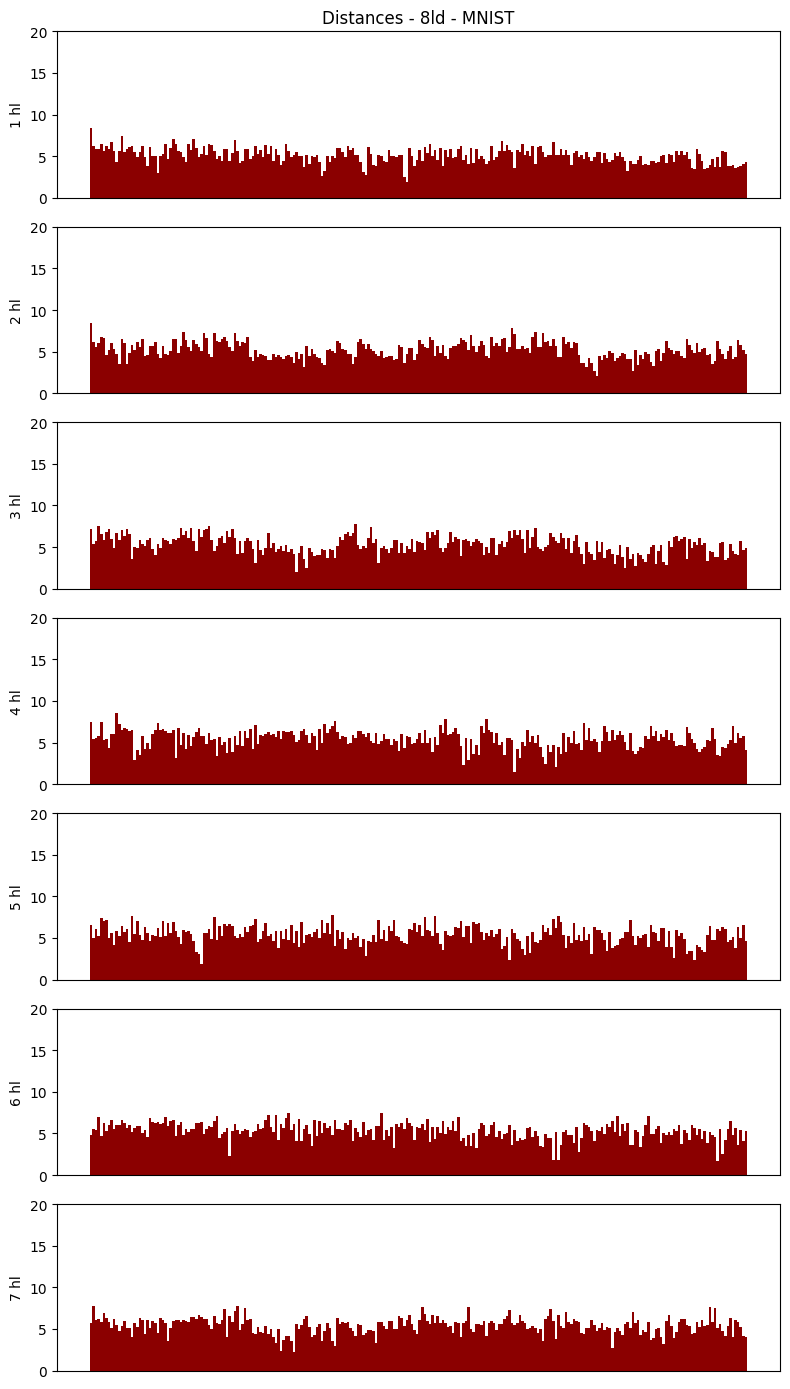

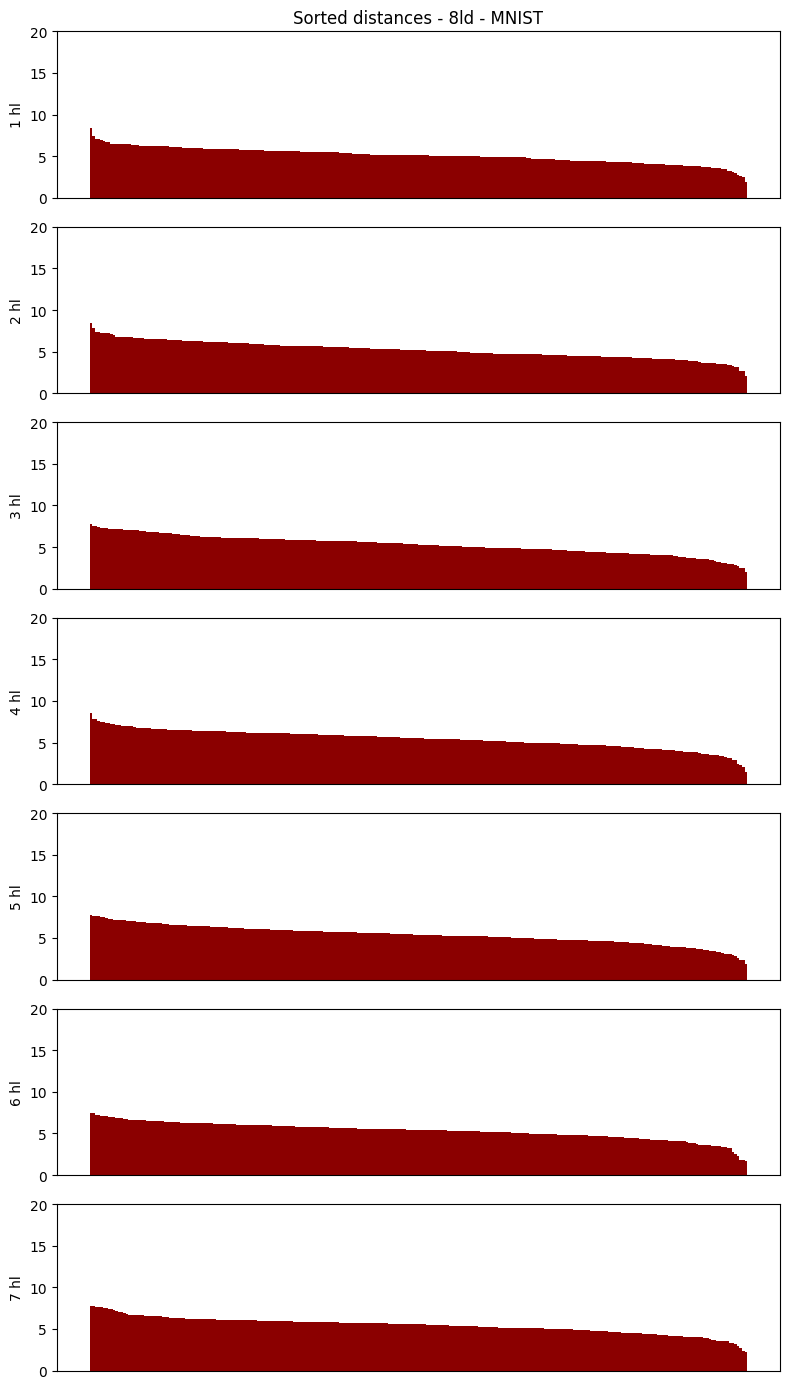

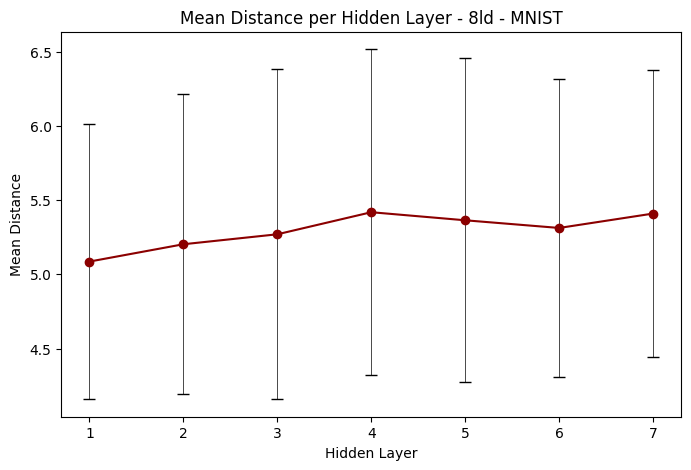

In [32]:
rep_hl_distances_loaded_mean = np.mean(rep_hl_distances_loaded, axis=0)
rep_hl_distances_loaded_mean_sorted = np.sort(rep_hl_distances_loaded_mean, axis=1)[:, ::-1]
x_range = []
for i in range(rep_hl_distances_loaded_mean.shape[0]):
    x_range.append(np.arange(rep_hl_distances_loaded_mean.shape[1]))
plot_multiple_distances_histograms(x_range, rep_hl_distances_loaded_mean, title=f"Distances - {ld}ld - {dataset}", y_range=(0,20))
plot_multiple_distances_histograms(x_range, rep_hl_distances_loaded_mean_sorted, title=f"Sorted distances - {ld}ld - {dataset}", y_range=(0, 20))
rep_hl_distances_loaded_mean_mean = np.mean(rep_hl_distances_loaded_mean, axis=1)
rep_hl_distances_loaded_mean_std = np.std(rep_hl_distances_loaded_mean, axis=1)

plot_mean_distance_per_hidden_layer(rep_hl_distances_loaded_mean_mean, rep_hl_distances_loaded_mean_std, ld, dataset)

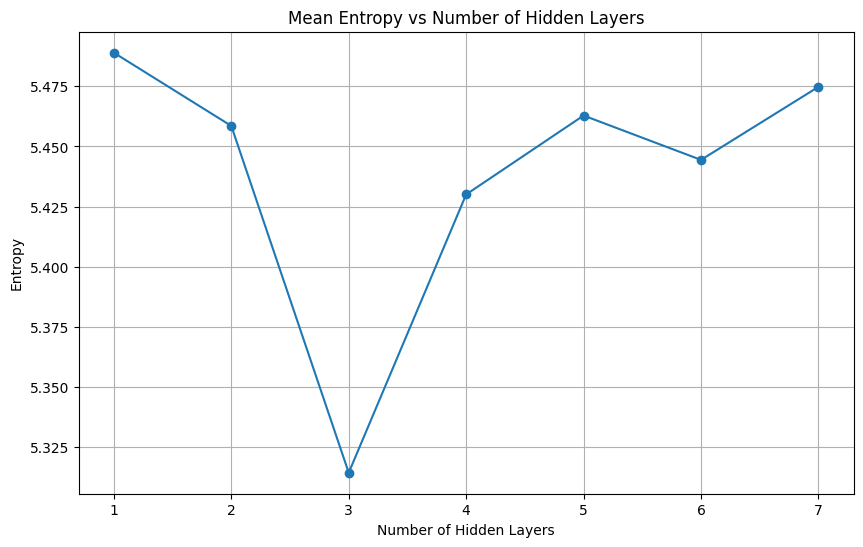

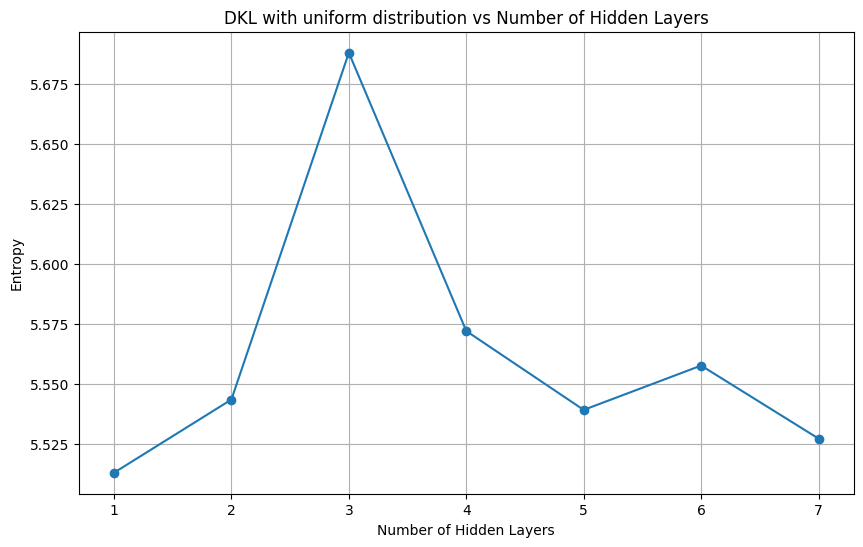

In [33]:
from AE.overlaps import compute_entropy_and_dkl
from AE.overlaps import plot_entropy_or_dkltouniform
entropy_mean, dkl_uniform = compute_entropy_and_dkl(rep_hl_datapoints_freq_loaded)
plot_entropy_or_dkltouniform(entropy_mean, 'Entropy', 'Mean Entropy vs Number of Hidden Layers', ld, dataset, save_dir=None)
plot_entropy_or_dkltouniform(dkl_uniform, 'Entropy', 'DKL with uniform distribution vs Number of Hidden Layers', ld, dataset, save_dir=None)